# Evaluate the effects of PS on P, TV, F, sEAdi etc

## Read-me
<!-- TODO ... Insert description ... -->

The code to consecutively:
<!-- TODO  Update code steps-->

## 1. Import code libraries

In [1]:
# Standard code libraries
import os
import sys
import glob
from pathlib import Path

import scipy
from scipy import interpolate as interp
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
%matplotlib widget

c:\Users\warnaarrsp\Miniconda3\envs\resurfemg_py310_dev\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Custom code libraries from the ReSurfEMG repository
# It uses the ReSurfEMG library version v0.2.1

import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt
import resurfemg.postprocessing.features as feat

from resurfemg.data_connector.tmsisdk_lite import Poly5Reader

from resurfemg.config.config import Config
config = Config()

In [3]:
def moving_baseline(signal, fs, window_length):
    #  Augmented moving baseline for EMGdi signals for baseline crossing detection

    # 2.a. Calculate the "default" moving baseline over the sEAdi data over a 7.5s 
    #     window
    rolling_baseline = np.zeros((len(signal), ))
    for idx in range(0, len(signal), int(fs/5)):
        start_i = max([0, idx-int(window_length/2)])
        end_i = min([len(signal), idx+int(window_length/2)])
        baseline_value = np.nanpercentile(signal[start_i:end_i], 33)
        
        for i in range(idx, min([idx+int(fs/5), len(signal)])):
            rolling_baseline[i] = baseline_value
    
    return rolling_baseline

def augmented_moving_baseline(signal, fs, window_length, augmented_perc):
    # 2.a. Calculate the "default" moving baseline over the sEAdi data over 
    #       a 7.5s window
    default_rolling_baseline = moving_baseline(signal, fs, window_length)

    # 2.b. Rolling standard deviation and mean over 7.5s window
    baseline_series = pd.Series(default_rolling_baseline)
    baseline_std = baseline_series.rolling(window_length, 
                                    min_periods=1, 
                                    center=True).std().values
    baseline_mean = baseline_series.rolling(window_length, 
                                    min_periods=1, 
                                    center=True).mean().values

    # 2.c. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
    ma_window = fs//2
    # augmented_perc = 25
    perc_window = fs

    s = pd.Series(signal - default_rolling_baseline)
    s_MA = s.rolling(window=ma_window, center=True).mean().values
    ds_dt = (s_MA[1:] - s_MA[:-1] ) * fs
    s_aug = signal[:-1] + np.abs(ds_dt)

    # 2.d. Run the moving median filter over the augmented signal to obtain the 
    #       baseline
    s_aug_rolling_baseline = np.zeros(
        (len(signal)-1, ))

    for idx in range(0, int(len(signal)-1), perc_window):
        start_i = max([0, idx-int(window_length)])
        end_i = min([len(signal)-1, idx+int(window_length)])

        baseline_value = np.nanpercentile(
            s_aug[start_i:end_i], augmented_perc)
        
        for i in range(idx, min([idx+int(perc_window), len(signal)-1])):
            s_aug_rolling_baseline[i] = 1.2 * baseline_value
    
    return s_aug_rolling_baseline, baseline_std, baseline_mean

## Initiation of output folder for experiments

In [4]:
# Input data path - The main directory where all data is loaded from
root_patient_data_directory = \
    config.get_directory('root_patient_data_directory')

# Output data - General path to dir for saving .csvs and plots
main_output_dir = os.path.join(config.get_directory('preprocessed'),
                    '2024-05_Baseline_effects')

if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

patient_idx = 0

## 2. Load the ventilator and sEMG data

2.a Select a patient

In [5]:
# Select the patient of interest

# Expected data structure:
# - Patient_01
# -- Measurement_date_XXXX_XX_01
# --- 001_Baseline
# --- 002_PS_step_01
# --- 003_PS_step_02
# --- 004_PS_step_03
# --- 005_PS_step_04
# -- Measurement_date_XXXX_XX_03
# --- 001_Baseline
# --- 002_PS_step_01
# --- 003_PS_step_02
# --- 004_PS_step_03
# --- 005_PS_step_04
# -- Patient_02
# -- Measurement_date_XXXX_XX_01
# etc.

# NB Run this cell once per patient!

patient_folders = glob.glob(
        os.path.join(root_patient_data_directory, '**',''), 
        recursive=False)

patients = []
for folder in patient_folders:
    name = Path(folder).parts[-1]
    patients.append(name)

patients.sort()

btn_pt = widgets.Dropdown(  
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('MST001', 'MST002', 'MST003', 'MST004', 'MST005', 'MST006', '…

2.b Select a measurement date, or PS trial

In [1016]:
# Select the measurement date (PS-trial) of interest for the selected patient
# measurement_date ~ PEEP-trial
 
# NB Run this cell once per patient/PS trial combination

patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders = glob.glob(
    os.path.join(root_patient_data_directory, patient, '**',''),
    recursive=False)
measurement_dates = []

for folder in measurement_folders:
    name = Path(folder).parts[-1]
    measurement_dates.append(name)

measurement_dates.sort()

# Initialise the analysis: empty the output parameter list and start at the 
# baseline measurement (index 0)
di_data_list = []
para_data_list = []
Paw_data_list = []
Vvent_data_list =[]
PS_step_idx = 0
plt.close('all')

# Set the default pipeline parameters
# Gating settings
gate_width_default = 0.10
gate_threshold_default = 0.30
gate_ECG_shift_default = -10
gate_twice = False

# RMS window
RMS_window_ms_default = 200

# Peak detection settings
time_shift_default = 0.5 - RMS_window_ms_default/1000/2
sEAdi_prominence_factor_default = 0.5
sEApara_prominence_factor_default = 0.5

btn_measurement = widgets.Dropdown(
    options=measurement_dates,
    value=measurement_dates[date_idx],
    description='Select measurement date:',
    parasabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', index=4, options=('2021-12-24_09-29-46', '2021-12-27_09-16-26…

2.c Select a PS step

In [1210]:
# Select PS step of interest recordings available for the selected patient/
# measurement_date

# NB Re-run this cell for each new PS trial, as it also empties output 
# parameter list (di_data_list)!


# Create output data folders
measurement_date = btn_measurement.value
date_idx = btn_measurement.index

output_path = os.path.join(main_output_dir, patient, measurement_date)
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Identify all PS step folders:
root_emg_directory = os.path.join(
    root_patient_data_directory, patient, measurement_date)

emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []
plt.close('all')

for file in emg_and_vent_files:
    if 'Draeger' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

emg_files.sort()
vent_files.sort()

list_of_numbers_string = []

for i in range(len(emg_files)):
    list_of_numbers_string.append(Path(emg_files[i]).parts[-2])

# Select the PEEP step of interest. The selection menu initialises at the third 
# but last (index -4) recording. The PEEP steps are named after the folders 
# containing the data files (.poly5) of interest.

btn_PS_step = widgets.Dropdown(
    options=list_of_numbers_string,
    value= list_of_numbers_string[PS_step_idx],
    description='Picked File:',
    disabled=False,
)
display(btn_PS_step)

Dropdown(description='Picked File:', index=4, options=('001', '002', '003', '004', '005', '006', '007', '008',…

In [1211]:
# Process selected option: the PEEP step of interest  
PS_step_chosen = btn_PS_step.value
PS_step_idx = int(btn_PS_step.index)
emg_file_chosen = emg_files[PS_step_idx]
vent_file_chosen = vent_files[PS_step_idx]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2022-01-03_13-11-09\005\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2022-01-03_13-11-09\005\Draeger_recording.Poly5


In [1212]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
emg_sample_rate = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
vent_sample_rate = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
# # Reshufle the channels if necessary
# y_emg = np.array([data_emg_samples[2, :], 
#                    data_emg_samples[0, :], 
#                    data_emg_samples[1, :]])
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/emg_sample_rate for i in range(len(y_emg[0, :]))]
t_vent = [i/vent_sample_rate for i in range(len(y_vent[0, :]))]

# Default settings for window of interest
# manoeuvres (Pocc)
# t_start_default = t_vent[-1]-61
# t_end_default = t_vent[-1]-1
t_start_default = t_vent[0]
t_end_default = t_vent[-1]

del data_emg_samples, data_vent_samples, data_emg, data_vent

btn_plt_raw = widgets.Dropdown(
    options=['Yes', 'No'],
    value='No',
    description='Plot raw data?',
    parasabled=False,
)
display(btn_plt_raw)

Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2022-01-03_13-11-09\005\EMG_recording.Poly5
	 Number of samples:  907792 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW\MST001\2022-01-03_13-11-09\005\Draeger_recording.Poly5
	 Number of samples:  44314 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


Dropdown(description='Plot raw data?', index=1, options=('Yes', 'No'), value='No')

In [1213]:
# Plot the raw data if wanted
if btn_plt_raw.value == 'Yes':
 
    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

    axis[0, 0].grid(True)
    axis[0, 0].plot(t_emg, y_emg[0])
    axis[0, 0].set(title='sEMG leads')
    axis[0, 0].set_ylabel('ECG (uV)')

    axis[1, 0].grid(True)
    axis[1, 0].plot(t_emg, y_emg[1])
    axis[1, 0].set_ylabel('sEMGdi (uV)')
    axis[1, 0].set_xlabel('t (s)')

    axis[2, 0].grid(True)
    axis[2, 0].plot(t_emg, y_emg[2])
    axis[2, 0].set_ylabel('sEMGpara (uV)')
    axis[2, 0].set_xlabel('t (s)')

    axis[0, 1].set(title='Ventilator data')
    axis[0, 1].grid(True)
    axis[0, 1].plot(t_vent, y_vent[0])
    axis[0, 1].set_ylabel('Paw (cmH2O)')

    axis[1, 1].grid(True)
    axis[1, 1].plot(t_vent, y_vent[1])
    axis[1, 1].set_ylabel('F (L/min)')

    axis[2, 1].grid(True)
    axis[2, 1].plot(t_vent, y_vent[2])
    axis[2, 1].set_ylabel('V (mL)')
    axis[2, 1].set_xlabel('t (s)')

## 3. Select the time window of interest

In [1214]:
start = t_start_default
end = t_end_default

start_s = int(float(start)* emg_sample_rate)
end_s = min([int(float(end)*emg_sample_rate), len(y_emg[0,:])-1])
start_vent_s = int(float(start)* vent_sample_rate)
end_vent_s = min(
    [int(float(end)* vent_sample_rate), len(y_vent[0,:])-1]
)

fig_w = (int(end_vent_s)-int(start_vent_s))//(vent_sample_rate*80)*12

## 4. Pre-process the sEMGdi

In [1215]:
# Eliminate the baseline wander from the data using a band-pass filter
bd_filtered_file_data = filt.emg_bandpass_butter_sample(
    y_emg, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
processed_data_emg_para = bd_filtered_file_data[2]

del y_emg

In [1216]:
# Gating settings

# Window size to plot the gating results from
plot_window = 5         

# QRS peak detection settings
# peak_fraction = 0.30 (default value)
peak_fraction = gate_threshold_default     # Minimal relative peak height
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)

# Shift of gated in samples relative to detected peaks      
# ECG_shift = -10 (default value)
ECG_shift = gate_ECG_shift_default

# Gate width in seconds
# gate_width = 0.10 (default value)
gate_width = gate_width_default
# gate_width = 0.15

Apply QRS gating

In [1217]:
# First run of QRS gating

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = bd_filtered_file_data[0]
ecg_rms = evl.full_rolling_rms(ecg, 10)
max_ecg_rms = max(
    ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(
    ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)

# The RMS filter is not centred. Therefore, shift the ECG peak locations
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = filt.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = filt.emg_bandpass_butter_sample(
    processed_data_emg_di, 20, 500, 2048, output='sos')
emg_para_h20 = filt.emg_bandpass_butter_sample(
    processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

ECG_gated = ecg_rm.gating(
    ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = ecg_rm.gating(
    emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_para_gated = ecg_rm.gating(
    emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


btn_gate_twice = widgets.Dropdown(
    options=['Yes', 'No'],
    value='Yes' if gate_twice else 'No',
    description='Gate twice?',
    parasabled=False,
)
display(btn_gate_twice)

Dropdown(description='Gate twice?', index=1, options=('Yes', 'No'), value='No')

In [1218]:
# Second run of QRS gating

if btn_gate_twice.value == 'Yes':
    gate_twice = True
else:
    gate_twice = False
    
# Second run of QRS gating, if selected with gate_twice == True
# This is usefull, e.g., in case of splitted QRS complex or pacing
if gate_twice == True:
    # Detect ECG peaks on 1Hz high-pass filtered signals
    ecg = ECG_gated
    ecg_rms = evl.full_rolling_rms(ecg, 10)
    max_ecg_rms = max(
        ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    min_ecg_rms = min(
        ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

    ECG_peaks, properties  = scipy.signal.find_peaks(
        ecg_rms, 
        height=peak_height, 
        width=peak_width*emg_sample_rate, 
        distance=peak_dist
    )
    # The RMS filter is not centred. Therefore, shift the ECG peak locations
    ECG_peaks = ECG_peaks - ECG_shift

    # Gate ECG and EMG signal
    # Fill methods: 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
    # 3: Moving average
    gate_fill_method = 3    
    gate_width_samples = int(gate_width*emg_sample_rate)

    gate_samples = list()
    for i in range(len(ECG_peaks)):
        for k in range(
            int(ECG_peaks[i]-gate_width_samples/2),
            int(ECG_peaks[i]+gate_width_samples/2)
        ):
            gate_samples.append(k)

    ECG_gated = ecg_rm.gating(
        ECG_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_di_gated = ecg_rm.gating(
        emg_di_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_para_gated = ecg_rm.gating(
        emg_para_gated, ECG_peaks, gate_width=gate_width_samples, method=3)

In [1219]:
btn_plt_gated = widgets.Dropdown(
    options=['Yes', 'No'],
    value='No',
    description='Plot gated data?',
    parasabled=False,
)
display(btn_plt_gated)

Dropdown(description='Plot gated data?', index=1, options=('Yes', 'No'), value='No')

In [1220]:
# Plot gating result if wanted
if btn_plt_gated.value == 'Yes':
    fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6), sharex=True)
    start_i = int(start_s)
    end_i = int(start_s+plot_window*2048)
    axis[0].grid(True)
    axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
    axis[0].set_ylabel('raw ECG (uV)')
    axis[0].set(title='leads in EMG')

    axis[1].grid(True)
    axis[1].plot(t_emg[start_i:end_i], ECG_gated[start_i:end_i])
    axis[1].set_ylabel('ECG gated (uV)')

    axis[2].grid(True)
    axis[2].plot(t_emg[start_i:end_i], emg_di_gated[start_i:end_i])
    axis[2].set_ylabel('EMGdi gated (uV)')

    axis[3].grid(True)
    axis[3].plot(t_emg[start_i:end_i], emg_para_gated[start_i:end_i])
    axis[3].set_ylabel('EMGpara gated (uV)')

    axis[4].grid(True)
    axis[4].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
    axis[4].set_ylabel('ECG rms (uV)')
    axis[4].hlines(
        y=peak_height, 
        xmin=t_emg[start_i], 
        xmax=t_emg[end_i],
        color = "C1"
    )
    axis[4].set_xlabel('t (s)')

    for idx in range(len(ECG_peaks)):
        if ((ECG_peaks[idx] > int(start_s)) 
            & (ECG_peaks[idx] < int(start_s+plot_window*2048))):
            axis[4].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


## 5. Calculate the sEMG envelope (sEAdi & sEApara)

In [1221]:
# Calculate the moving-RMS over the sEMG signal
# RMS_window_ms = 200 (default value)
RMS_window_ms = RMS_window_ms_default

RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

# Pad the EMG signal before gating to get a centralised, rather than a causal
# moving RMS signal
pre_samp = int(np.ceil(RMS_windows_samp/2))
post_samp = int(np.floor(RMS_windows_samp/2))
padding_pre = np.zeros((pre_samp,))
padding_end = np.zeros((post_samp,))

emg_di_gated_padded = np.concatenate((padding_pre, emg_di_gated, padding_end))
sEAdi_padded = evl.full_rolling_rms(emg_di_gated_padded, RMS_windows_samp)
sEAdi = sEAdi_padded[:-RMS_windows_samp]

emg_para_gated_padded = np.concatenate(
    (padding_pre, emg_para_gated, padding_end))
sEApara_padded = evl.full_rolling_rms(emg_para_gated_padded, RMS_windows_samp)
sEApara = sEApara_padded[:-RMS_windows_samp]

btn_plt_RMS = widgets.Dropdown(
    options=['Yes', 'No'],
    value='No',
    description='Plot RMS data?',
    parasabled=False,
)
display(btn_plt_RMS)

Dropdown(description='Plot RMS data?', index=1, options=('Yes', 'No'), value='No')

In [1222]:
# Plot RMS results if wanted
if btn_plt_RMS.value == 'Yes':

    fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6), sharex=True)
    axis[0].set(title='leads in EMG')
    axis[0].grid(True)
    axis[0].plot(t_emg[int(start_s):int(end_s)], 
                processed_data_emg_di[int(start_s):int(end_s)])
    axis[0].plot(t_emg[int(start_s):int(end_s)], sEAdi[int(start_s):int(end_s)])
    axis[0].set_ylabel('sEMGdi (uV)')

    axis[1].grid(True)
    axis[1].plot(t_emg[int(start_s):int(end_s)], sEAdi[int(start_s):int(end_s)])
    axis[1].set_ylabel('sEAdi (uV)')

    axis[2].grid(True)
    axis[2].plot(t_emg[int(start_s):int(end_s)], 
                processed_data_emg_para[int(start_s):int(end_s)])
    axis[2].plot(t_emg[int(start_s):int(end_s)], sEApara[int(start_s):int(end_s)])
    axis[2].set_ylabel('sEMGpara (uV)')

    axis[3].grid(True)
    axis[3].plot(t_emg[int(start_s):int(end_s)], sEApara[int(start_s):int(end_s)])
    axis[3].set_ylabel('sEApara (uV)')

    axis[4].grid(True)
    axis[4].plot(t_vent[int(start_vent_s):int(end_vent_s)], 
                y_vent[2][int(start_vent_s):int(end_vent_s)])
    axis[4].set_ylabel('Vvent (mL)')
    axis[4].set_xlabel('t (s)')

## 6. Calculate the Paw and sEAdi moving baselines

In [1223]:
# Baseline windows
baseline_W_emg = int(7.5 * emg_sample_rate)  # window length
baseline_W_vent = int(7.5 * vent_sample_rate)  # window length

augmented_perc = 25

In [1224]:
# 1. Calculate the moving baseline over the Paw signal over a 7.5s window
# P_rolling_baseline = np.zeros(
#     (len(y_vent[0, int(start_vent_s):int(end_vent_s)]), ))
# for idx in range(0, 
#                  int(end_vent_s)-int(start_vent_s), 
#                  int(vent_sample_rate/5)
# ):
#     start_i = max([int(start_vent_s), int(
#         start_vent_s)+idx-int(baseline_W_vent/2)])
#     end_i = min([int(end_vent_s), int(start_vent_s) +
#                 idx+int(baseline_W_vent/2)])
#     P_rolling_baseline[idx] = np.percentile(y_vent[0, start_i:end_i], 33)

#     baseline_value_P = np.percentile(y_vent[0, start_i:end_i], 33)
#     for i in range(idx, 
#             min([idx+int(vent_sample_rate/5), 
#                  int(end_vent_s)-int(start_vent_s)])
#     ):
#         P_rolling_baseline[i] = baseline_value_P

P_rolling_baseline = moving_baseline(
    y_vent[0, int(start_vent_s):int(end_vent_s)], 
    vent_sample_rate, 
    baseline_W_vent)

In [1225]:
# Augmented moving baseline for EMGdi signals for baseline crossing detection

# 2.a. Calculate the "default" moving baseline over the sEAdi data over a 7.5s 
#     window
sEAdi_rolling_baseline = moving_baseline(
    sEAdi[int(start_s):int(end_s)], 
    emg_sample_rate, 
    baseline_W_emg)

# 2.b. Rolling standard deviation and mean over 7.5s window
# 2.c. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
# 2.d. Run the moving median filter over the augmented signal to obtain the 
#       baseline
(sEAdi_aug_rolling_baseline, 
 di_baseline_std, 
 di_baseline_mean) = augmented_moving_baseline(
    sEAdi[int(start_s):int(end_s)], 
    emg_sample_rate, 
    baseline_W_emg,
    augmented_perc)

# sEAdi_rolling_baseline = np.zeros((len(sEAdi[int(start_s):int(end_s)]), ))
# for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
#     start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
#     end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
#     baseline_value_emg_di = np.nanpercentile(
#         sEAdi[start_i:end_i], 33)
    
#     for i in range(idx, 
#                    min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])
#     ):
#         sEAdi_rolling_baseline[i] = baseline_value_emg_di


# di_baseline_series = pd.Series(sEAdi_rolling_baseline)
# di_baseline_std = di_baseline_series.rolling(baseline_W_emg, 
#                                  min_periods=1, 
#                                  center=True).std().values
# di_baseline_mean = di_baseline_series.rolling(baseline_W_emg, 
#                                  min_periods=1, 
#                                  center=True).mean().values

# # 2.c. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
# ma_window = emg_sample_rate//2
# augmented_perc = 25
# perc_window = emg_sample_rate

# y_di_RMS = sEAdi[int(start_s):int(end_s)]
# s_di = pd.Series(y_di_RMS - sEAdi_rolling_baseline)
# sEAdi_MA = s_di.rolling(window=ma_window, center=True).mean().values
# dsEAdi_dt = (sEAdi_MA[1:] - sEAdi_MA[:-1] ) * emg_sample_rate
# sEAdi_aug = y_di_RMS[:-1] + np.abs(dsEAdi_dt)

# # 2.d. Run the moving median filter over the augmented signal to obtain the 
# #       baseline
# sEAdi_aug_rolling_baseline = np.zeros(
#     (len(sEAdi[int(start_s):int(end_s)-1]), ))

# for idx in range(0, int(end_s-1)-int(start_s), perc_window):
#     start_i = max([0, idx-int(baseline_W_emg)])
#     end_i = min([int(end_s-start_s-1), idx+int(baseline_W_emg)])

#     baseline_value_emg_di = np.nanpercentile(
#         sEAdi_aug[start_i:end_i], augmented_perc)
    
#     for i in range(idx, 
#                    min([idx+int(perc_window), int(end_s-1)-int(start_s)])
#     ):
#         sEAdi_aug_rolling_baseline[i] = 1.2 * baseline_value_emg_di

In [1226]:
# Augmented moving baseline for EMGpara signals for baseline crossing detection

# 3.a. Calculate the "default" moving baseline over the sEApara data over a 7.5s 
#     window
sEApara_rolling_baseline = moving_baseline(
    sEApara[int(start_s):int(end_s)], 
    emg_sample_rate, 
    baseline_W_emg)

# sEApara_rolling_baseline = np.zeros((len(sEApara[int(start_s):int(end_s)]), ))
# for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
#     start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
#     end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
#     baseline_value_emg_para = np.nanpercentile(
#         sEApara[start_i:end_i], 33)
    
#     for i in range(idx, 
#                    min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])
#     ):
#         sEApara_rolling_baseline[i] = baseline_value_emg_para

# 3.b. Rolling standard deviation and mean over 7.5s window
# 3.c. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
# 3.d. Run the moving median filter over the augmented signal to obtain the 
#       baseline

(sEApara_aug_rolling_baseline, 
 para_baseline_std, 
 para_baseline_mean) = augmented_moving_baseline(
    sEApara[int(start_s):int(end_s)], 
    emg_sample_rate, 
    baseline_W_emg,
    augmented_perc)

# para_baseline_series = pd.Series(sEApara_rolling_baseline)
# para_baseline_std = para_baseline_series.rolling(baseline_W_emg, 
#                                  min_periods=1, 
#                                  center=True).std().values
# para_baseline_mean = para_baseline_series.rolling(baseline_W_emg, 
#                                  min_periods=1, 
#                                  center=True).mean().values

# # 3.c. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
# ma_window = emg_sample_rate//2
# augmented_perc = 25
# perc_window = emg_sample_rate

# y_para_RMS = sEApara[int(start_s):int(end_s)]
# s_para = pd.Series(y_para_RMS - sEApara_rolling_baseline)
# sEApara_MA = s_para.rolling(window=ma_window, center=True).mean().values
# dsEApara_dt = (sEApara_MA[1:] - sEApara_MA[:-1] ) * emg_sample_rate
# sEApara_aug = y_para_RMS[:-1] + np.abs(dsEApara_dt)

# # 3.d. Run the moving median filter over the augmented signal to obtain the 
# #       baseline
# sEApara_aug_rolling_baseline = np.zeros(
#     (len(sEApara[int(start_s):int(end_s)-1]), ))

# for idx in range(0, int(end_s-1)-int(start_s), perc_window):
#     start_i = max([0, idx-int(baseline_W_emg)])
#     end_i = min([int(end_s-start_s-1), idx+int(baseline_W_emg)])

#     baseline_value_emg_para = np.nanpercentile(
#         sEApara_aug[start_i:end_i], augmented_perc)
    
#     for i in range(idx, 
#                    min([idx+int(perc_window), int(end_s-1)-int(start_s)])
#     ):
#         sEApara_aug_rolling_baseline[i] = 1.2 * baseline_value_emg_para

## 7. Identify sEAdi, sEApara, and ventilator peaks of interest

In [1227]:
# EMG peak detection parameters:

# Threshold peak height as fraction of max peak height 
# sEAdi_prominence_factor = 0.5 (default value)
sEAdi_prominence_factor = 1.0

# sEApara_prominence_factor = 0.5 (default value)
sEApara_prominence_factor = 1.0

emg_peak_width = 0.2
emg_peak_distance = 40/60

# Ventilator delay
# time_shift_default = 0.5 (default value)
time_shift = time_shift_default = 0.5 - RMS_window_ms/1000/2

# Breath & Tidal volume detection
# TV_percentile_default = 75 (default value)
TV_percentile = 75 
# TV_fraction_default = 0.2 (default value)
TV_fraction = 0.2 

print("The sEAdi detection threshold is set at:\n", 
      100*sEAdi_prominence_factor, '%')
print("The sEApara detection threshold is set at:\n", 
      100*sEApara_prominence_factor, '%')

The sEAdi detection threshold is set at:
 100.0 %
The sEApara detection threshold is set at:
 100.0 %


sEAdi peak detection

In [1228]:
# Find diaphragm sEAdi peaks and baseline crossings using the new baseline

y_di_RMS = sEAdi[int(start_s):int(end_s)]
treshold = 0
width = int(emg_peak_width * emg_sample_rate)
prominence = sEAdi_prominence_factor * \
    (np.nanpercentile(y_di_RMS - sEAdi_rolling_baseline, 75) 
     + np.nanpercentile(y_di_RMS - sEAdi_rolling_baseline, 50))
distance = int(emg_peak_distance * emg_sample_rate)
sEAdi_peaks, properties = scipy.signal.find_peaks(
    y_di_RMS[:-1]-sEAdi_aug_rolling_baseline, 
    height=treshold, 
    prominence=prominence, 
    width=width, 
    distance=distance
)

# Amplify the augmented moving baseline according to the Coefficient of 
# Variation (CoV = std/mean)
if len(sEAdi_peaks) > 0:
    sEAdi_rolling_baseline_aug = sEAdi_rolling_baseline * (1+ 
        np.nanmedian(y_di_RMS[sEAdi_peaks]) * di_baseline_std 
        / di_baseline_mean **2
    )
else:
    sEAdi_rolling_baseline_aug = sEAdi_rolling_baseline * (1+ 
        np.nanmedian(y_di_RMS) * di_baseline_std 
        / di_baseline_mean **2
    )

# Detect the sEAdi on- and offsets 
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di_RMS - sEAdi_rolling_baseline_aug)) != 0)[:, 0]

sEAdi_starts = np.zeros(sEAdi_peaks.shape, dtype=int)
sEAdi_ends = np.zeros(sEAdi_peaks.shape, dtype=int)
sEAdi_75perc = np.zeros(sEAdi_peaks.shape, dtype=int)
incomplete_first_index = 0
incomplete_last_index = False
for idx in range(len(sEAdi_peaks)):
    signal_sign_sub = np.sign(
        y_di_RMS[:sEAdi_peaks[idx]] 
        - sEAdi_rolling_baseline_aug[:sEAdi_peaks[idx]]
    )
    baseline_crossings_idx_sub = np.argwhere(
        np.diff(signal_sign_sub) != 0)[:, 0]
    if len(baseline_crossings_idx_sub) == 0:
        incomplete_first_index += 1
    else:
        a = np.argmin(sEAdi_peaks[idx] - baseline_crossings_idx_sub)
    
        sEAdi_starts[idx] = int(baseline_crossings_idx[a])
        
        if a < len(baseline_crossings_idx) - 1:
            sEAdi_ends[idx] = int(baseline_crossings_idx[a+1])

            sEAdi_75perc[idx] = sEAdi_peaks[idx] + np.argmin(np.sign(
                y_di_RMS[sEAdi_peaks[idx]:sEAdi_ends[idx]] 
                - 0.75 * (y_di_RMS[sEAdi_peaks[idx]] 
                          - y_di_RMS[sEAdi_ends[idx]])
            ))

        else:
            incomplete_last_index = True

if incomplete_first_index > 0:
    sEAdi_starts = numpy.delete(sEAdi_starts, range(incomplete_first_index))
    sEAdi_peaks = numpy.delete(sEAdi_peaks, range(incomplete_first_index))
    sEAdi_75perc = numpy.delete(sEAdi_75perc, range(incomplete_first_index))
    sEAdi_ends = numpy.delete(sEAdi_ends, range(incomplete_first_index))

if incomplete_last_index is True:
    sEAdi_starts = numpy.delete(sEAdi_starts, -1)
    sEAdi_peaks = numpy.delete(sEAdi_peaks, -1)
    sEAdi_75perc = numpy.delete(sEAdi_75perc, -1)
    sEAdi_ends = numpy.delete(sEAdi_ends, -1)


In [1229]:
# Find parasternal sEApara peaks and baseline crossings using the new baseline

y_para_RMS = sEApara[int(start_s):int(end_s)]
treshold = 0
width = int(emg_peak_width * emg_sample_rate)
prominence = sEApara_prominence_factor * \
    (np.nanpercentile(y_para_RMS - sEApara_rolling_baseline, 75) 
     + np.nanpercentile(y_para_RMS - sEApara_rolling_baseline, 50))
distance = int(emg_peak_distance * emg_sample_rate)
sEApara_peaks, properties = scipy.signal.find_peaks(
    y_para_RMS[:-1]-sEApara_aug_rolling_baseline, 
    height=treshold,
    prominence=prominence, 
    width=width, 
    distance=distance
)

# Amplify the augmented moving baseline according to the Coefficient of 
# Variation (CoV = std/mean)
if len(sEApara_peaks) > 0:
    sEApara_rolling_baseline_aug = sEApara_rolling_baseline * (1+ 
        np.nanmedian(y_para_RMS[sEApara_peaks]) * para_baseline_std 
        / para_baseline_mean **2
    )
else:
    sEApara_rolling_baseline_aug = sEApara_rolling_baseline * (1+ 
        np.nanmedian(y_para_RMS) * para_baseline_std 
        / para_baseline_mean **2
    )

# Detect the sEApara on- and offsets 
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_para_RMS - sEApara_rolling_baseline_aug)) != 0)[:, 0]

sEApara_starts = np.zeros(sEApara_peaks.shape, dtype=int)
sEApara_ends = np.zeros(sEApara_peaks.shape, dtype=int)
sEApara_75perc = np.zeros(sEApara_peaks.shape, dtype=int)
incomplete_first_index = 0
incomplete_last_index = False
for idx in range(len(sEApara_peaks)):
    signal_sign_sub = np.sign(
        y_para_RMS[:sEApara_peaks[idx]] 
        - sEApara_rolling_baseline_aug[:sEApara_peaks[idx]]
    )
    baseline_crossings_idx_sub = np.argwhere(
        np.diff(signal_sign_sub) != 0)[:, 0]
    if len(baseline_crossings_idx_sub) == 0:
        incomplete_first_index += 1
    else:
        a = np.argmin(sEApara_peaks[idx] - baseline_crossings_idx_sub)
    
        sEApara_starts[idx] = int(baseline_crossings_idx[a])
        
        if a < len(baseline_crossings_idx) - 1:
            sEApara_ends[idx] = int(baseline_crossings_idx[a+1])

            sEApara_75perc[idx] = sEApara_peaks[idx] + np.argmin(np.sign(
                y_para_RMS[sEApara_peaks[idx]:sEApara_ends[idx]] 
                - 0.75 * (y_para_RMS[sEApara_peaks[idx]] 
                          - y_para_RMS[sEApara_ends[idx]])
            ))
        else:
            incomplete_last_index = True

if incomplete_first_index > 0:
    sEApara_starts = numpy.delete(sEApara_starts, range(incomplete_first_index))
    sEApara_peaks = numpy.delete(sEApara_peaks, range(incomplete_first_index))
    sEApara_75perc = numpy.delete(sEApara_75perc, range(incomplete_first_index))
    sEApara_ends = numpy.delete(sEApara_ends, range(incomplete_first_index))

if incomplete_last_index is True:
    sEApara_starts = numpy.delete(sEApara_starts, -1)
    sEApara_peaks = numpy.delete(sEApara_peaks, -1)
    sEApara_75perc = numpy.delete(sEApara_75perc, -1)
    sEApara_ends = numpy.delete(sEApara_ends, -1)


Pneumatic data detection

In [1230]:
# Detect pneumatic peaks and the set PEEP level
# Find end-expiration samples by finding the minimal values in V_vent
V_ei_PKS_all, _ = scipy.signal.find_peaks(y_vent[2])

# Detect tidal peaks with a volume at least 20% of the upper quartile TV
TV_75_pct = np.percentile(y_vent[2, V_ei_PKS_all], TV_percentile)
threshold = TV_fraction * TV_75_pct
V_ei_PKS, _ = scipy.signal.find_peaks(y_vent[2], height=threshold)

if len(sEApara_starts) > 0:
    while sEApara_starts[0]/emg_sample_rate*vent_sample_rate > V_ei_PKS[0]:
        # Eliminate tidal peaks before the first full sEApara peak
        V_ei_PKS = np.delete(V_ei_PKS, 0)

# Find the set PEEP level
# Find end-expiration samples by finding the minimal values in V_vent
V_ee_PKS, _ = scipy.signal.find_peaks(-y_vent[2])

# Eliminate end tidal volumes before the first tidal volume peak
while V_ee_PKS[0] < V_ei_PKS[0]:
    V_ee_PKS = np.delete(V_ee_PKS, 0)

# Eliminate double end tidal volumes before the first tidal volume peak
for idx in range(len(V_ei_PKS)-1):
    Vee_idxs_tmp = V_ee_PKS[(V_ee_PKS > V_ei_PKS[idx]) 
                        & (V_ee_PKS < V_ei_PKS[idx+1])]
    stay_idx = np.argmin(y_vent[2, Vee_idxs_tmp])
    if len(Vee_idxs_tmp) > 1:
        stay_idx
        Vee_idxs_tmp = np.delete(Vee_idxs_tmp, stay_idx)

        for _, peak_idx in enumerate(Vee_idxs_tmp):
            V_ee_PKS = np.delete(V_ee_PKS, np.argwhere(peak_idx == V_ee_PKS))

# Eliminate tidal peak from which the end-expiration is not detected
while V_ee_PKS[-1] < V_ei_PKS[-1]:
    V_ei_PKS = np.delete(V_ei_PKS, -1)


# The remaining tidal volumes:
print("The detected tidal volumes are:\n", 
      'Median: ' + str(np.nanmedian(y_vent[2, V_ei_PKS])), ' mL\n'
      'Min: ' + str(np.nanmin(y_vent[2, V_ei_PKS])), ' mL\n'
      'Max: ' + str(np.nanmax(y_vent[2, V_ei_PKS])), ' mL\n')

# Calculate PEEP as the median value of Paw at end-expiration
PEEP_set = np.round(np.median(y_vent[0, V_ee_PKS]))

print("The detected PEEP level is:\n", PEEP_set, ' cmH2O \n')

# Calculate PS as the median value of the driving pressure just before end-
# inspiration, rounded to a multiple of 3 cmH2O
Paw_PKS, _ = scipy.signal.find_peaks(y_vent[0] - PEEP_set, prominence=2.5)
i_delta = vent_sample_rate // 5
P_peaks_median = [np.nanmedian(
    y_vent[0, Paw_PKS[idx]-i_delta:Paw_PKS[idx]+i_delta]
           ) for idx in range(len(Paw_PKS))]
# PS_set = np.round(np.median(P_peaks_median - PEEP_set) / 3) * 3
PS_set = np.round(np.nanmedian(P_peaks_median - PEEP_set))

print("The detected PS level is:\n", PS_set, ' cmH2O')

The detected tidal volumes are:
 Median: 526.5095825195312  mL
Min: 120.1521987915039  mL
Max: 669.6121826171875  mL

The detected PEEP level is:
 5.0  cmH2O 

The detected PS level is:
 3.0  cmH2O


# Link pneumatic and EMG peaks

In [1231]:
# Convert ventilator samples to EMG sample rate
P_peaks_converted = Paw_PKS / vent_sample_rate * emg_sample_rate
V_peaks_converted = V_ei_PKS / vent_sample_rate * emg_sample_rate

# Link sEAdi peak closest to pneumatic peaks
sEAdi_links = np.zeros((len(sEAdi_peaks), 2), dtype=int) - 1

for idx in range(len(sEAdi_peaks)):
    # Linked pressure peak
    sEAdi_links[idx, 0] = np.argmin(
        np.abs(sEAdi_peaks[idx] + time_shift_default * emg_sample_rate 
               - P_peaks_converted)
    )

    # Linked volume peak
    sEAdi_links[idx, 1] = np.argmin(
        np.abs(sEAdi_peaks[idx] + time_shift_default * emg_sample_rate 
               - V_peaks_converted)
    )

# Link sEApara peak closest to pneumatic peaks
sEApara_links = np.zeros((len(sEApara_peaks), 2), dtype=int) - 1

for idx in range(len(sEApara_peaks)):
    # Linked pressure peak
    sEApara_links[idx, 0] = np.argmin(
        np.abs(sEApara_peaks[idx] + time_shift_default * emg_sample_rate 
               - P_peaks_converted)
    )

    # Linked volume peak
    sEApara_links[idx, 1] = np.argmin(
        np.abs(sEApara_peaks[idx] + time_shift_default * emg_sample_rate 
               - V_peaks_converted)
    )

# Convert EMGsamples to ventilator sample rate
sEAdi_peaks_converted = sEAdi_peaks / emg_sample_rate * vent_sample_rate
sEApara_peaks_converted = sEApara_peaks / emg_sample_rate * vent_sample_rate

# Link pressure peaks to the closest EMG peaks
Paw_links = np.zeros((len(Paw_PKS), 2), dtype=int) - 1

for idx in range(len(Paw_PKS)):
    # Linked pressure peak
    if len(sEAdi_peaks) > 0:
        Paw_links[idx, 0] = np.argmin(
            np.abs(sEAdi_peaks_converted + time_shift_default * vent_sample_rate
                   - Paw_PKS[idx])
        )

    # Linked volume peak
    if len(sEApara_peaks) > 0:
        Paw_links[idx, 1] = np.argmin(
            np.abs(sEApara_peaks_converted 
                   + time_shift_default * vent_sample_rate
                   - Paw_PKS[idx])
        )

# Link pressure peaks to the closest EMG peaks
Vvent_links = np.zeros((len(V_ei_PKS), 2), dtype=int) - 1

for idx in range(len(V_ei_PKS)):
    # Linked pressure peak
    if len(sEAdi_peaks) > 0:
        Vvent_links[idx, 0] = np.argmin(
            np.abs(sEAdi_peaks_converted 
                   + time_shift_default * vent_sample_rate
                   - V_ei_PKS[idx])
        )

    # Linked volume peak
    if len(sEApara_peaks) > 0:
        Vvent_links[idx, 1] = np.argmin(
            np.abs(sEApara_peaks_converted 
                   + time_shift_default * vent_sample_rate
                   - V_ei_PKS[idx])
        )

In [1232]:
# Data sanity check: Make sure sEAdi peaks have been detected correctly
if (any(sEAdi_starts == 0) or any(sEAdi_peaks == 0)  
    or any(sEAdi_ends == 0)):
    print('The number of detected sEAdi onsets, peaks, offsets using the new '
          + 'moving baseline method, is not the same, please examine the data. '
          + 'Selected another window or file, accordingly')
else:
    print(str(len(sEAdi_peaks)) + ' sEAdi peak(s) were detected using the '
          'new moving baseline method. You may continue!')

121 sEAdi peak(s) were detected using the new moving baseline method. You may continue!


In [1233]:
# Data sanity check: Make sure sEApara peaks have been detected correctly
if (any(sEApara_starts == 0) or any(sEApara_peaks == 0)  
    or any(sEApara_ends == 0)):
    print('The number of detected sEApara onsets, peaks, offsets using the new '
          + 'moving baseline method, is not the same, please examine the data. '
          + 'Selected another window or file, accordingly')
else:
    print(str(len(sEApara_peaks)) + ' sEApara peak(s) were detected using the '
          'new moving baseline method. You may continue!')

120 sEApara peak(s) were detected using the new moving baseline method. You may continue!


## 8. Plot the detected Paw, Vvent, sEAdi and sEApara peaks

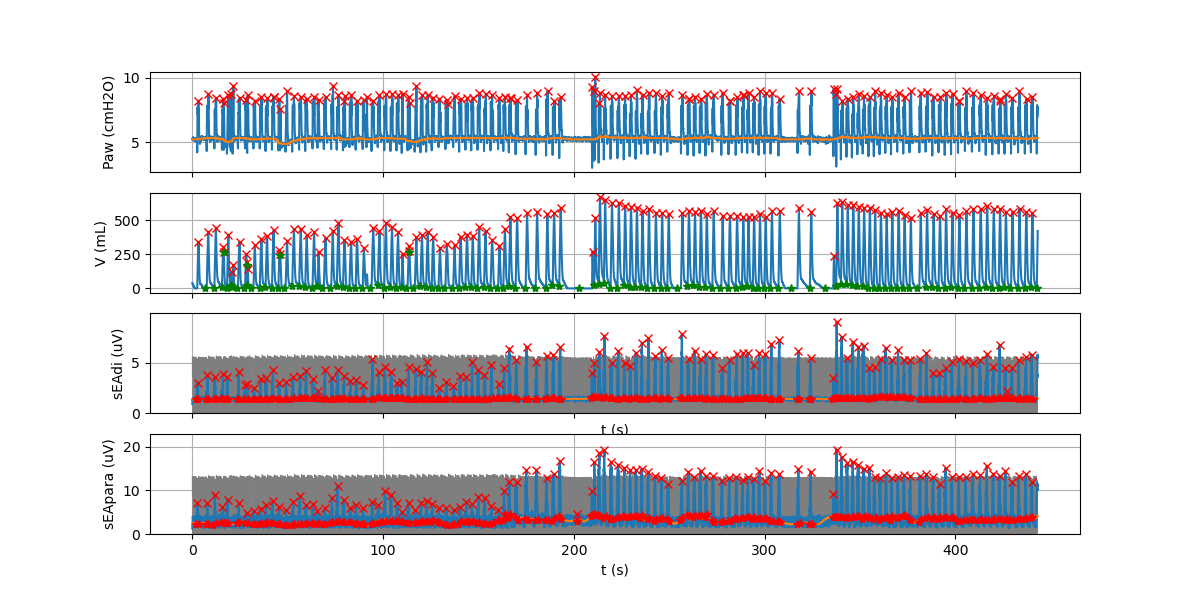

In [1234]:
# Plot entire selected time window with indicated peaks
# Paw:
fig_1, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)

Paw_sel = y_vent[0, start_vent_s:end_vent_s+1]
axis[0].grid(True)
#   Paw signal
axis[0].plot([y / vent_sample_rate for y in range(len(Paw_sel))], Paw_sel)
#   Paw moving baseline
axis[0].plot([y / vent_sample_rate for y in range(len(P_rolling_baseline))],
             P_rolling_baseline)
#   Detected peaks, and on- and offsets 
axis[0].plot(Paw_PKS/vent_sample_rate, Paw_sel[Paw_PKS], "x", color="r")
axis[0].set_ylabel('Paw (cmH2O)')

# V_vent:
axis[1].grid(True)
V_vent = y_vent[2, int(start_vent_s):int(end_vent_s)+1]
axis[1].plot([y / vent_sample_rate for y in range(len(V_vent))], V_vent)
axis[1].plot(V_ei_PKS/vent_sample_rate, V_vent[V_ei_PKS], "x", color="r")
axis[1].plot(V_ee_PKS/vent_sample_rate, V_vent[V_ee_PKS], "*", color="g")
axis[1].set_ylabel('V (mL)')

# sEAdi:
axis[2].grid(True)
N_samp = len(sEAdi[int(start_s):int(end_s)])
# Normalised ECG for reference
if len(sEAdi_peaks) > 0:
    axis[2].plot(np.array(t_emg[start_s:end_s]), 
                        ecg_rms[start_s:end_s]/
                        max(ecg_rms[start_s:end_s])*
                        np.percentile(y_di_RMS[sEAdi_peaks], 75), 
                        'tab:gray', linewidth=0.5)
else:
    axis[2].plot(np.array(t_emg[start_s:end_s]), 
                    ecg_rms[start_s:end_s]/
                    max(ecg_rms[start_s:end_s])*
                    np.percentile(y_di_RMS, 75), 
                    'tab:gray', linewidth=0.5)
#   sEAdi signal
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             sEAdi[int(start_s):int(end_s)])
#   Rolling baseline
axis[2].plot([y / emg_sample_rate 
              for y in range(len(sEAdi_rolling_baseline_aug))],
             sEAdi_rolling_baseline_aug[:int(end_s)-int(start_s)])
#   Detected peaks, and on- and offsets 
axis[2].plot(sEAdi_peaks/emg_sample_rate,
             y_di_RMS[sEAdi_peaks], "x", color="r")
axis[2].plot(sEAdi_starts/ emg_sample_rate,
             y_di_RMS[sEAdi_starts], '*r')
axis[2].plot(sEAdi_ends / emg_sample_rate,
             y_di_RMS[sEAdi_ends], '*r')

axis[2].set_ylabel('sEAdi (uV)')
axis[2].set_xlabel('t (s)')
if len(sEAdi_peaks) > 0:
    axis[2].set_ylim([0, 1.4*np.percentile(y_di_RMS[sEAdi_peaks], 95)])

# sEApara:
axis[3].grid(True)
N_samp = len(sEApara[int(start_s):int(end_s)])
# Normalised ECG for reference
if len(sEApara_starts) > 0:
    axis[3].plot(np.array(t_emg[start_s:end_s]), 
                        ecg_rms[start_s:end_s]/
                        max(ecg_rms[start_s:end_s])*
                        np.percentile(y_para_RMS[sEApara_peaks], 75), 
                        'tab:gray', linewidth=0.5)
else:
    axis[3].plot(np.array(t_emg[start_s:end_s]), 
                        ecg_rms[start_s:end_s]/
                        max(ecg_rms[start_s:end_s])*
                        np.percentile(y_para_RMS, 75), 
                        'tab:gray', linewidth=0.5)
#   sEApara signal
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             sEApara[int(start_s):int(end_s)])
#   Rolling baseline
axis[3].plot([y / emg_sample_rate 
              for y in range(len(sEApara_rolling_baseline_aug))],
             sEApara_rolling_baseline_aug[:int(end_s)-int(start_s)])
#   Detected peaks, and on- and offsets 
axis[3].plot(sEApara_peaks/emg_sample_rate,
             y_para_RMS[sEApara_peaks], "x", color="r")
axis[3].plot(sEApara_starts/ emg_sample_rate,
             y_para_RMS[sEApara_starts], '*r')
axis[3].plot(sEApara_ends / emg_sample_rate,
             y_para_RMS[sEApara_ends], '*r')

axis[3].set_ylabel('sEApara (uV)')
axis[3].set_xlabel('t (s)')
if len(sEApara_starts) > 0:
    axis[3].set_ylim([0, 1.4*np.percentile(y_para_RMS[sEApara_peaks], 95)])

## 9. Calculate the ETPdi and ETPpara per peak

In [1235]:
# Calculate the electrical time product over sEAdi (ETPdi)

ETP_di_occs = np.zeros((len(sEAdi_peaks),))
y_di_min = np.zeros((len(sEAdi_peaks),))
ETP_di_baseline = np.zeros((len(sEAdi_peaks),))
ETP_di_baseline_old = np.zeros((len(sEAdi_peaks),))
noise_heights_di = np.zeros((len(sEAdi_peaks),))
for idx in range(len(sEAdi_peaks)):
    start_i = sEAdi_starts[idx]
    end_i = sEAdi_ends[idx]

    # Area under the baseline (AUB)
    baseline_start_i = max([0, sEAdi_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di_RMS) - 1, sEAdi_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])

    
    ETP_di_baseline[idx] = np.trapz(
        sEAdi_rolling_baseline_aug[start_i:end_i+1] 
        - y_di_min[idx], dx=1/emg_sample_rate
    )

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di_RMS[start_i:end_i+1] 
        - sEAdi_rolling_baseline_aug[start_i:end_i+1],
        dx=1/emg_sample_rate
    ) + ETP_di_baseline[idx]

    noise_heights_di[idx] = np.median(sEAdi_rolling_baseline[start_i:end_i])

In [1236]:
# Calculate the electrical time product over sEApara (ETPpara)

ETP_para_occs = np.zeros((len(sEApara_peaks),))
y_para_min = np.zeros((len(sEApara_peaks),))
ETP_para_baseline = np.zeros((len(sEApara_peaks),))
ETP_para_baseline_old = np.zeros((len(sEApara_peaks),))
noise_heights_para = np.zeros((len(sEApara_peaks),))
for idx in range(len(sEApara_peaks)):
    start_i = sEApara_starts[idx]
    end_i = sEApara_ends[idx]

    # Area under the baseline (AUB)
    baseline_start_i = max([0, sEApara_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_para_RMS) - 1, sEApara_peaks[idx] + 5*emg_sample_rate])
    y_para_min[idx] = min(y_para_RMS[baseline_start_i:baseline_end_i])

    
    ETP_para_baseline[idx] = np.trapz(
        sEApara_rolling_baseline_aug[start_i:end_i+1] 
        - y_para_min[idx], dx=1/emg_sample_rate
    )

    # EMG Time Product (ETP) parasternal
    ETP_para_occs[idx] = np.trapz(
        y_para_RMS[start_i:end_i+1] 
        - sEApara_rolling_baseline_aug[start_i:end_i+1],
        dx=1/emg_sample_rate
    ) + ETP_para_baseline[idx]

    noise_heights_para[idx] = np.median(sEApara_rolling_baseline[start_i:end_i])

## 10. Evaluate the quality of the Pocc and sEAdi peaks

10.a Successively occluded breaths: N/A

10.b Pocc release quality: N/A

10.c Interpeak time for ECG, sEAdi and sEApara peaks 

In [1237]:
# Determine electrophysiological interpeak distance
t_delta_ecg_med = np.median(np.array(t_emg)[ECG_peaks[1:]] 
                            - np.array(t_emg)[ECG_peaks[:-1]])
t_delta_di_med = np.median(np.array(t_emg)[sEAdi_peaks[1:]] 
                           - np.array(t_emg)[sEAdi_peaks[:-1]])
t_delta_para_med = np.median(np.array(t_emg)[sEApara_peaks[1:]] 
                           - np.array(t_emg)[sEApara_peaks[:-1]])

10.d sEAdi and sEApara signal-to-noise ratio (SNR)

In [1238]:
# Calculate signal-to-noise ratios. 
#   As the true signal and noise are not known,
#   the SNR is estimated as the maximum divided by the median of the moving 
#   baseline in a 1 s window around the peak.

SNR_di = feat.snr_pseudo(
    src_signal=sEAdi[int(start_s):int(end_s)], 
    peaks=sEAdi_peaks, 
    baseline=sEAdi_rolling_baseline_aug[:int(end_s)-int(start_s)]
)

SNR_para = feat.snr_pseudo(
    src_signal=sEApara[int(start_s):int(end_s)], 
    peaks=sEApara_peaks, 
    baseline=sEApara_rolling_baseline_aug[:int(end_s)-int(start_s)]
)

10.e Area under the baseline

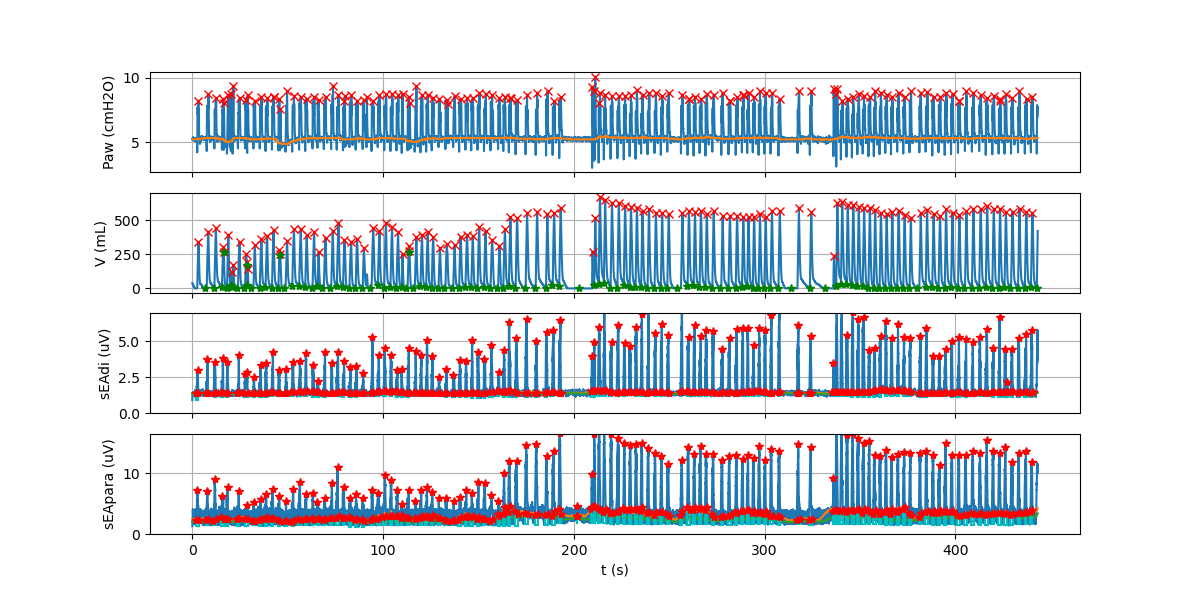

In [1239]:
# Plot the Area Under the Baseline (AUB) 
# NB1 AUB is calculated above in step 9.
# NB2 AUB is plotted in cyan 

# Paw:
fig_2, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)

Paw_sel = y_vent[0, start_vent_s:end_vent_s+1]
axis[0].grid(True)
#   Paw signal
axis[0].plot([y / vent_sample_rate for y in range(len(Paw_sel))], Paw_sel)
#   Paw moving baseline
axis[0].plot([y / vent_sample_rate for y in range(len(P_rolling_baseline))],
             P_rolling_baseline)
#   Detected peaks, and on- and offsets 
axis[0].plot(Paw_PKS/vent_sample_rate, Paw_sel[Paw_PKS], "x", color="r")
axis[0].set_ylabel('Paw (cmH2O)')

# V_vent:
axis[1].grid(True)
V_vent = y_vent[2, start_vent_s:end_vent_s+1]
axis[1].plot([y / vent_sample_rate for y in range(len(V_vent))], V_vent)
axis[1].plot(V_ei_PKS/vent_sample_rate, V_vent[V_ei_PKS], "x", color="r")
axis[1].plot(V_ee_PKS/vent_sample_rate, V_vent[V_ee_PKS], "*", color="g")
axis[1].set_ylabel('V (mL)')

# sEAdi:
axis[2].grid(True)
N_samp = len(sEAdi[int(start_s):int(end_s)])
#   sEAdi signal
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             sEAdi[int(start_s):int(end_s)])
#   Rolling baseline
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             sEAdi_rolling_baseline_aug[:int(end_s)-int(start_s)])
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             sEAdi_rolling_baseline[:int(end_s)-int(start_s)])

# Plot sEAdi area under the baseline (AUB)
for idx in range(len(sEAdi_peaks)):
    start_i = sEAdi_starts[idx]
    end_i = sEAdi_ends[idx]
    
    #   Area under the baseline (AUB)
    axis[2].plot([t_emg[start_i], t_emg[end_i+1]], 
                      [y_di_min[idx], y_di_min[idx]], 'c')
    axis[2].plot([t_emg[start_i], t_emg[start_i]], 
                      [y_di_RMS[start_i], y_di_min[idx]], 'c')
    axis[2].plot([t_emg[end_i], t_emg[end_i]], 
                      [y_di_RMS[end_i], y_di_min[idx]], 'c')
    #   Detected peaks, and on- and offsets
    axis[2].plot(t_emg[sEAdi_peaks[idx]],
                      y_di_RMS[sEAdi_peaks[idx]], '*r')
    axis[2].plot(t_emg[start_i], y_di_RMS[start_i], '*r')
    axis[2].plot(t_emg[end_i], y_di_RMS[end_i], '*r')


axis[2].set_ylabel('sEAdi (uV)')
if len(sEAdi_peaks) > 0:
    axis[2].set_ylim([0, 1.2*np.percentile(y_di_RMS[sEAdi_peaks], 75)])

# sEApara:
axis[3].grid(True)
N_samp = len(sEApara[int(start_s):int(end_s)])
#   sEApara signal
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             sEApara[int(start_s):int(end_s)])
#   Rolling baseline
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             sEApara_rolling_baseline_aug[:int(end_s)-int(start_s)])
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             sEApara_rolling_baseline[:int(end_s)-int(start_s)])

# Plot sEApara area under the baseline (AUB)
for idx in range(len(sEApara_peaks)):
    start_i = sEApara_starts[idx]
    end_i = sEApara_ends[idx]
    
    #   Area under the baseline (AUB)
    axis[3].plot([t_emg[start_i], t_emg[end_i+1]], 
                      [y_para_min[idx], y_para_min[idx]], 'c')
    axis[3].plot([t_emg[start_i], t_emg[start_i]], 
                      [y_para_RMS[start_i], y_para_min[idx]], 'c')
    axis[3].plot([t_emg[end_i], t_emg[end_i]], 
                      [y_para_RMS[end_i], y_para_min[idx]], 'c')
    #   Detected peaks, and on- and offsets
    axis[3].plot(t_emg[sEApara_peaks[idx]],
                      y_para_RMS[sEApara_peaks[idx]], '*r')
    axis[3].plot(t_emg[start_i], y_para_RMS[start_i], '*r')
    axis[3].plot(t_emg[end_i], y_para_RMS[end_i], '*r')


axis[3].set_ylabel('sEApara (uV)')
axis[3].set_xlabel('t (s)')
if len(sEApara_peaks) > 0:
    axis[3].set_ylim([0, 1.2*np.percentile(y_para_RMS[sEApara_peaks], 75)])

10.e Waveform morphology

In [1240]:
# Evaluate sEAdi and sEApara peak quality according to waveform morphology
# NB1 The fitted bell curve is plotted in green 

# Define the bell-curve function
def func(x, a, b, c):
    return a * np.exp(-(x-b)**2 / c**2)

# Evaluate bell-curve error of sEApara peaks
ETP_di_bell_error = np.zeros((len(sEAdi_peaks),))
for idx in range(len(sEAdi_peaks)):
    start_i = sEAdi_starts[idx]
    end_i = sEAdi_ends[idx]
    
    baseline_start_i = max([0, sEAdi_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di_RMS) - 1, sEAdi_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])

    # Too little samples to fit parameters to --> Add additional datapoints
    if end_i - start_i < 3:
        plus_idx = 3 - (end_i - start_i)
    else:
        plus_idx = 0

    try:
        popt, pcov = curve_fit(func, 
                        t_emg[start_i:end_i+1], 
                        y_di_RMS[start_i:end_i+1]-y_di_min[idx],
                        bounds=([-np.inf, t_emg[sEAdi_peaks[idx]]-0.5, -np.inf], 
                                [np.inf, t_emg[sEAdi_peaks[idx]]+0.5, np.inf])
                        )
        

        ETP_di_bell_error[idx] = np.trapz(
            np.sqrt((y_di_RMS[start_i:end_i+1] - 
            (func(t_emg[start_i:end_i+1], *popt)+y_di_min[idx])) **2),
            dx=1/emg_sample_rate
        )
    except(RuntimeError):
        ETP_di_bell_error[idx] = np.nan

# Evaluate bell-curve error of sEApara peaks
ETP_para_bell_error = np.zeros((len(sEApara_peaks),))
for idx in range(len(sEApara_peaks)):
    start_i = sEApara_starts[idx]
    end_i = sEApara_ends[idx]
    
    baseline_start_i = max([0, sEApara_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_para_RMS) - 1, sEApara_peaks[idx] + 5*emg_sample_rate])
    y_para_min[idx] = min(y_para_RMS[baseline_start_i:baseline_end_i])

    # Too little samples to fit parameters to --> Add additional datapoints
    if end_i - start_i < 3:
        plus_idx = 3 - (end_i - start_i)
    else:
        plus_idx = 0
    
    try:
        popt, pcov = curve_fit(func, 
                        t_emg[start_i:end_i+1], 
                        y_para_RMS[start_i:end_i+1]-y_para_min[idx],
                        bounds=([-np.inf, t_emg[sEApara_peaks[idx]]-0.5, -np.inf], 
                                [np.inf, t_emg[sEApara_peaks[idx]]+0.5, np.inf])
                        )

        ETP_para_bell_error[idx] = np.trapz(
            np.sqrt((y_para_RMS[start_i:end_i+1] - 
            (func(t_emg[start_i:end_i+1], *popt)+y_para_min[idx])) **2),
            dx=1/emg_sample_rate
        )
    except(RuntimeError):
        ETP_para_bell_error[idx] = np.nan

In [1241]:
print('Unable to fit bell curve to sEAdi in ' 
      + str(np.count_nonzero(np.isnan(ETP_di_bell_error))) + ' case(s).\n'
      'Unable to fit bell curve to sEApara in ' 
      + str(np.count_nonzero(np.isnan(ETP_para_bell_error))) + ' case(s).'
)

Unable to fit bell curve to sEAdi in 0 case(s).
Unable to fit bell curve to sEApara in 0 case(s).


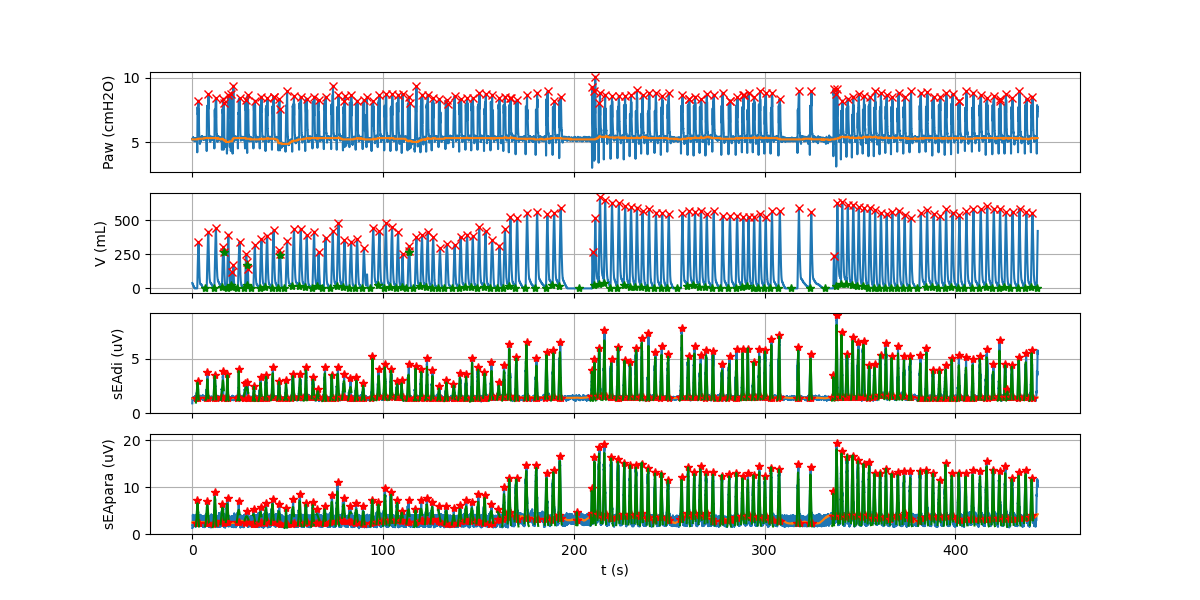

In [1242]:
# Plot sEAdi peak quality according to waveform morphology

# Define the bell-curve function
def func(x, a, b, c):
    return a * np.exp(-(x-b)**2 / c**2)

fig_3, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)

Paw_sel = y_vent[0, start_vent_s:end_vent_s+1]
axis[0].grid(True)
#   Paw signal
axis[0].plot([y / vent_sample_rate for y in range(len(Paw_sel))], Paw_sel)
#   Paw moving baseline
axis[0].plot([y / vent_sample_rate for y in range(len(P_rolling_baseline))],
             P_rolling_baseline)
#   Detected peaks, and on- and offsets 
axis[0].plot(Paw_PKS/vent_sample_rate, Paw_sel[Paw_PKS], "x", color="r")
axis[0].set_ylabel('Paw (cmH2O)')

# V_vent:
axis[1].grid(True)
V_vent = y_vent[2, start_vent_s:end_vent_s+1]
axis[1].plot([y / vent_sample_rate for y in range(len(V_vent))], V_vent)
axis[1].plot(V_ei_PKS/vent_sample_rate, V_vent[V_ei_PKS], "x", color="r")
axis[1].plot(V_ee_PKS/vent_sample_rate, V_vent[V_ee_PKS], "*", color="g")
axis[1].set_ylabel('V (mL)')

# sEAdi:
axis[2].grid(True)
N_samp = len(sEAdi[int(start_s):int(end_s)])
#   sEAdi signal
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             sEAdi[int(start_s):int(end_s)])
#   Rolling baseline
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             sEAdi_rolling_baseline_aug[:int(end_s)-int(start_s)])

# Plot bell-curve error of sEAdi peaks
for idx in range(len(sEAdi_peaks)):
    start_i = sEAdi_starts[idx]
    end_i = sEAdi_ends[idx]

    start_plot_i = max([0, start_i-emg_sample_rate//4])
    end_plot_i = min([N_samp, end_i+emg_sample_rate//4])
    
    baseline_start_i = max([0, sEAdi_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di_RMS) - 1, sEAdi_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])

    # Too little samples to fit parameters to --> Add additional datapoints
    if end_i - start_i < 3:
        plus_idx = 3 - (end_i - start_i)
    else:
        plus_idx = 0
    
    # Plot the fitted bell-curve relative to the sEAdi peak
    # sEAdi peak, on- and off-set
    axis[2].plot(t_emg[sEAdi_peaks[idx]],
                      y_di_RMS[sEAdi_peaks[idx]], '*r')
    axis[2].plot(t_emg[start_i], y_di_RMS[start_i], '*r')
    axis[2].plot(t_emg[end_i], y_di_RMS[end_i], '*r')
    try:
        popt, pcov = curve_fit(func, 
                        t_emg[start_i:end_i+1], 
                        y_di_RMS[start_i:end_i+1]-y_di_min[idx],
                        bounds=([-np.inf, t_emg[sEAdi_peaks[idx]]-0.5, -np.inf], 
                                [np.inf, t_emg[sEAdi_peaks[idx]]+0.5, np.inf])
                        )

        # Fitted bell-curve in green
        axis[2].plot(t_emg[start_plot_i:end_plot_i+1], 
                        func(t_emg[start_plot_i:end_plot_i+1], *popt)
                        + y_di_min[idx], 'g')
    except(RuntimeError):
        pass

axis[2].set_ylabel('sEAdi (uV)')
if len(sEAdi_peaks) > 0:
    axis[2].set_ylim([0, 1.4*np.percentile(y_di_RMS[sEAdi_peaks], 90)])

# sEApara:
axis[3].grid(True)
N_samp = len(sEAdi[int(start_s):int(end_s)])
#   sEApara signal
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             sEApara[int(start_s):int(end_s)])
#   Rolling baseline
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             sEApara_rolling_baseline_aug[:int(end_s)-int(start_s)])
# Plot bell-curve error of sEApara peaks
for idx in range(len(sEApara_peaks)):
    start_i = sEApara_starts[idx]
    end_i = sEApara_ends[idx]

    start_plot_i = max([0, start_i-emg_sample_rate//4])
    end_plot_i = min([N_samp, end_i+emg_sample_rate//4])
    
    baseline_start_i = max([0, sEApara_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_para_RMS) - 1, sEApara_peaks[idx] + 5*emg_sample_rate])
    y_para_min[idx] = min(y_para_RMS[baseline_start_i:baseline_end_i])

    # Too little samples to fit parameters to --> Add additional datapoints
    if end_i - start_i < 3:
        plus_idx = 3 - (end_i - start_i)
    else:
        plus_idx = 0
    
    # Plot the fitted bell-curve relative to the sEApara peak
    # sEApara peak, on- and off-set
    axis[3].plot(t_emg[sEApara_peaks[idx]],
                      y_para_RMS[sEApara_peaks[idx]], '*r')
    axis[3].plot(t_emg[start_i], y_para_RMS[start_i], '*r')
    axis[3].plot(t_emg[end_i], y_para_RMS[end_i], '*r')
    try:
        popt, pcov = curve_fit(func, 
                        t_emg[start_i:end_i+1], 
                        y_para_RMS[start_i:end_i+1]-y_para_min[idx],
                        bounds=([-np.inf, t_emg[sEApara_peaks[idx]]-0.5, -np.inf], 
                                [np.inf, t_emg[sEApara_peaks[idx]]+0.5, np.inf])
                        )

        # Fitted bell-curve in green
        axis[3].plot(t_emg[start_plot_i:end_plot_i+1], 
                        func(t_emg[start_plot_i:end_plot_i+1], *popt)
                        + y_para_min[idx], 'g')
    except(RuntimeError):
        pass

axis[3].set_ylabel('sEApara (uV)')
axis[3].set_xlabel('t (s)')
if len(sEApara_peaks) > 0:
    axis[3].set_ylim([0, 1.4*np.percentile(y_para_RMS[sEApara_peaks], 90)])

## 11. Add the outcome data to a dataframe

In [1243]:
print(patient + ' / ' + measurement_date + ' / ' + PS_step_chosen)

MST001 / 2022-01-03_13-11-09 / 005


In [1244]:
fig_1.set_figwidth(fig_w)
fig_1.savefig(main_output_dir + '/' + patient + '/' + measurement_date
              + '/' + measurement_date + '_' + patient + '_' 
              + PS_step_chosen + '_timeplots_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_2.set_figwidth(fig_w)
fig_2.savefig(main_output_dir + '/' + patient + '/' + measurement_date
              + '/' + measurement_date + '_' + patient + '_' 
              + PS_step_chosen + '_AUB_errors_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_3.set_figwidth(fig_w)
fig_3.savefig(main_output_dir + '/' + patient + '/' + measurement_date
              + '/' + measurement_date + '_' + patient + '_' 
              + PS_step_chosen + '_bell_errors_'+str(int(gate_width*1000))+'.png', 
              dpi=300)

In [1245]:
# di_data_list = []
# para_data_list = []
# Paw_data_list = []
# Vvent_data_list = []



# # PS_step_del = '002'
# PS_step_del = PS_step_chosen
# df_di = df_di.drop(df_di[df_di['measurement'] == PS_step_del].index)
# df_para = df_para.drop(df_para[df_para['measurement'] == PS_step_del].index)
# df_Paw = df_Paw.drop(df_Paw[df_Paw['measurement'] == PS_step_del].index)
# df_Vvent = df_Vvent.drop(df_Vvent[df_Vvent['measurement'] == PS_step_del].index)

# di_data_list = list(df_di.values)
# para_data_list = list(df_para.values)
# Paw_data_list = list(df_Paw.values)
# Vvent_data_list = list(df_Vvent.values)

# df_di

In [1246]:
# Store sEAdi parameters in a dataframe (~ table)
columns_di = ['patient', 'measurement', 'PEEP_set', 'PS_set', 
              'ETP_di', 'SNR_di', 'ETP_di_baseline', 'ETP_di_bell_SE',
              't_delta_di_med', 't_delta_ecg_med', 
              't_di_peak', 't_di_start', 't_di_75', 't_di_end', 
              'P_peak_associated', 'V_peak_associated', 
              'noise_di']

df_di = pd.DataFrame(di_data_list, columns=columns_di)

if len(df_di[df_di['measurement'] == PS_step_chosen]) == 0:
    for idx in range(len(sEAdi_peaks)):
        data_di_tmp = [patient, PS_step_chosen, PEEP_set, PS_set, 
                       ETP_di_occs[idx], SNR_di[idx], 
                       ETP_di_baseline[idx], ETP_di_bell_error[idx], 
                       t_delta_di_med, t_delta_ecg_med,
                       sEAdi_peaks[idx]/emg_sample_rate, 
                       sEAdi_starts[idx]/emg_sample_rate,
                       sEAdi_75perc[idx]/emg_sample_rate, 
                       sEAdi_ends[idx]/emg_sample_rate,
                       sEAdi_links[idx, 0]/emg_sample_rate,
                       sEAdi_links[idx, 1]/emg_sample_rate,
                       noise_heights_di[idx]
                    ]
        
        di_data_list.append(data_di_tmp)
    
    df_di = pd.DataFrame(di_data_list, columns=columns_di)
else:
    print('Data of PS step ' + PS_step_chosen + ' already added to the ' 
          + 'dataframe. Don''t add the data twice!')
    
df_di

,patient,measurement,PEEP_set,PS_set,ETP_di,SNR_di,ETP_di_baseline,ETP_di_bell_SE,t_delta_di_med,t_delta_ecg_med,t_di_peak,t_di_start,t_di_75,t_di_end,P_peak_associated,V_peak_associated,noise_di
0,MST001,001,5.0,4.0,2.367645,3.927262,0.401528,0.370486,3.14209,0.546875,2.720703,2.051758,2.957520,3.281738,0.000488,0.000000,1.473343
1,MST001,001,5.0,4.0,2.580096,3.928246,0.300482,0.299651,3.14209,0.546875,5.185059,4.696289,5.530273,5.652832,0.000977,0.000488,1.472810
2,MST001,001,5.0,4.0,2.861665,3.831010,0.406710,0.482084,3.14209,0.546875,7.963867,7.380371,8.311035,8.629883,0.001465,0.000977,1.477674
3,MST001,001,5.0,4.0,2.169915,3.118647,0.362337,0.356675,3.14209,0.546875,10.860352,10.088867,11.105957,11.292969,0.001953,0.001465,1.446545
4,MST001,001,5.0,4.0,1.797965,3.230244,0.252705,0.181776,3.14209,0.546875,13.539551,13.052246,13.824219,13.949219,0.002441,0.001953,1.440753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,MST001,005,5.0,3.0,0.311723,1.473643,0.154204,0.081299,3.33252,0.541016,427.254883,426.826172,427.254883,427.331055,0.064941,0.059082,1.454698
557,MST001,005,5.0,3.0,2.392474,2.957805,0.402296,0.258709,3.33252,0.541016,429.598633,428.964355,430.003906,430.154297,0.065430,0.059570,1.463811
558,MST001,005,5.0,3.0,2.575468,3.529974,0.328393,0.455058,3.33252,0.541016,433.240234,432.634277,433.478027,433.721680,0.065918,0.060059,1.431807
559,MST001,005,5.0,3.0,2.536219,3.738663,0.349718,0.616103,3.33252,0.541016,437.012207,436.168457,437.177734,437.334473,0.066406,0.060547,1.447136


In [1247]:
# Store sEApara parameters in a dataframe (~ table)
columns_para = ['patient', 'measurement', 'PEEP_set', 'PS_set', 
              'ETP_para', 'SNR_para', 'ETP_para_baseline', 'ETP_para_bell_SE',
              't_delta_para_med', 't_delta_ecg_med', 
              't_para_peak', 't_para_start', 't_para_75', 't_para_end', 
              'Paw_associated', 'Vvent_associated', 'noise_para']

df_para = pd.DataFrame(para_data_list, columns=columns_para)

if len(df_para[df_para['measurement'] == PS_step_chosen]) == 0:
    for idx in range(len(sEApara_peaks)):
        data_para_tmp = [patient, PS_step_chosen, PEEP_set, PS_set, 
                       ETP_para_occs[idx], SNR_para[idx], 
                       ETP_para_baseline[idx], ETP_para_bell_error[idx], 
                       t_delta_para_med, t_delta_ecg_med,
                       sEApara_peaks[idx]/emg_sample_rate, 
                       sEApara_starts[idx]/emg_sample_rate,
                       sEApara_75perc[idx]/emg_sample_rate, 
                       sEApara_ends[idx]/emg_sample_rate,
                       sEApara_links[idx, 0]/emg_sample_rate,
                       sEApara_links[idx, 1]/emg_sample_rate,
                       noise_heights_para[idx]
                    ]
        
        para_data_list.append(data_para_tmp)
    
    df_para = pd.DataFrame(para_data_list, columns=columns_para)
else:
    print('Data of PS step ' + PS_step_chosen + ' already added to the ' 
          + 'dataframe. Don''t add the data twice!')
    
df_para

,patient,measurement,PEEP_set,PS_set,ETP_para,SNR_para,ETP_para_baseline,ETP_para_bell_SE,t_delta_para_med,t_delta_ecg_med,t_para_peak,t_para_start,t_para_75,t_para_end,Paw_associated,Vvent_associated,noise_para
0,MST001,001,5.0,4.0,8.883000,2.863697,2.664568,0.730756,3.127930,0.546875,2.738770,2.062988,3.093750,3.169434,0.000488,0.000000,3.960023
1,MST001,001,5.0,4.0,11.124382,3.678892,3.929072,2.306318,3.127930,0.546875,5.148438,4.700195,5.414551,6.336914,0.000977,0.000488,3.892267
2,MST001,001,5.0,4.0,8.551548,3.095729,2.741859,0.363496,3.127930,0.546875,7.899414,7.399414,8.331543,8.471680,0.001465,0.000977,3.839161
3,MST001,001,5.0,4.0,8.216292,3.013221,2.870209,0.714923,3.127930,0.546875,10.812012,10.111328,11.087402,11.206543,0.001953,0.001465,3.567473
4,MST001,001,5.0,4.0,7.093141,2.713370,2.751933,0.526464,3.127930,0.546875,13.590332,12.952148,13.836914,13.939941,0.002441,0.001953,3.470237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,MST001,005,5.0,3.0,8.992894,4.345855,2.624764,1.162636,3.400391,0.541016,426.181152,425.514160,426.373047,426.823730,0.064941,0.059082,2.932149
561,MST001,005,5.0,3.0,9.644230,3.651601,2.770173,0.859679,3.400391,0.541016,429.726562,428.754883,430.003906,430.249512,0.065430,0.059570,2.989683
562,MST001,005,5.0,3.0,8.620089,3.857188,2.384767,0.797560,3.400391,0.541016,433.249023,432.533691,433.442871,433.814941,0.065918,0.060059,2.895457
563,MST001,005,5.0,3.0,8.163426,3.850902,2.042433,1.020703,3.400391,0.541016,436.932129,436.208008,437.109863,437.203125,0.066406,0.060547,2.903299


In [1248]:
np.median(noise_heights_di), np.median(noise_heights_para)

(1.4234074789868967, 2.6203938148112025)

In [1249]:
# Store the Paw output parameters in a dataframe (~ table)
columns_Paw = ['patient', 'measurement', 'PEEP_set', 'PS_set', 
                   'Paw_peak', 't_P_peak', 
                   'sEAdi_associated', 'sEApara_associated'
               ]

df_Paw = pd.DataFrame(Paw_data_list, columns=columns_Paw)

if len(df_Paw[df_Paw['measurement'] == PS_step_chosen]) == 0:
    for idx in range(len(Paw_PKS)):
        Paw_tmp = [patient, PS_step_chosen, PEEP_set, PS_set,
                   Paw_sel[Paw_PKS[idx]],
                   Paw_PKS[idx]/vent_sample_rate, 
                   Paw_links[idx, 0]/emg_sample_rate,
                   Paw_links[idx, 1]/emg_sample_rate
                   ]
        
        Paw_data_list.append(Paw_tmp)
    
    df_Paw = pd.DataFrame(Paw_data_list, columns=columns_Paw)
else:
    print('Data of PS step ' + PS_step_chosen + ' already added to the ' 
          + 'dataframe. Don''t add the data twice!')
    
df_Paw

,patient,measurement,PEEP_set,PS_set,Paw_peak,t_P_peak,sEAdi_associated,sEApara_associated
0,MST001,001,5.0,4.0,10.7727,0.48,0.000000,0.000000
1,MST001,001,5.0,4.0,10.6727,3.21,0.000000,0.000000
2,MST001,001,5.0,4.0,11.0228,5.69,0.000488,0.000488
3,MST001,001,5.0,4.0,10.6727,8.45,0.000977,0.000977
4,MST001,001,5.0,4.0,10.5726,11.23,0.001465,0.001465
...,...,...,...,...,...,...,...,...
589,MST001,005,5.0,3.0,8.7222,426.47,0.056152,0.056152
590,MST001,005,5.0,3.0,8.4221,429.87,0.057129,0.056641
591,MST001,005,5.0,3.0,8.9722,433.57,0.057617,0.057129
592,MST001,005,5.0,3.0,8.3721,437.29,0.058105,0.057617


In [1250]:
# Store the Vvent output parameters in a dataframe (~ table)

columns_Vvent = ['patient', 'measurement', 'PEEP_set', 'PS_set', 
                   'TV', 't_TV_peak', 
                   'sEAdi_associated', 'sEApara_associated'
               ]

df_Vvent = pd.DataFrame(Vvent_data_list, columns=columns_Vvent)

if len(df_Vvent[df_Vvent['measurement'] == PS_step_chosen]) == 0:
    for idx in range(len(V_ei_PKS)):
        Vvent_tmp = [patient, PS_step_chosen, PEEP_set, PS_set,
                     V_vent[V_ei_PKS[idx]],
                     V_ei_PKS[idx]/vent_sample_rate, 
                     Vvent_links[idx, 0]/emg_sample_rate,
                     Vvent_links[idx, 1]/emg_sample_rate
                    ]
        
        Vvent_data_list.append(Vvent_tmp)
    
    df_Vvent = pd.DataFrame(Vvent_data_list, columns=columns_Vvent)
else:
    print('Data of PS step ' + PS_step_chosen + ' already added to the ' 
          + 'dataframe. Don''t add the data twice!')
    
df_Vvent

,patient,measurement,PEEP_set,PS_set,TV,t_TV_peak,sEAdi_associated,sEApara_associated
0,MST001,001,5.0,4.0,484.658813,3.22,0.000000,0.000000
1,MST001,001,5.0,4.0,529.209595,5.70,0.000488,0.000488
2,MST001,001,5.0,4.0,510.309296,8.47,0.000977,0.000977
3,MST001,001,5.0,4.0,513.009277,11.25,0.001465,0.001465
4,MST001,001,5.0,4.0,480.608704,14.03,0.001953,0.001953
...,...,...,...,...,...,...,...,...
571,MST001,005,5.0,3.0,557.560120,426.48,0.056152,0.056152
572,MST001,005,5.0,3.0,562.960205,429.91,0.057129,0.056641
573,MST001,005,5.0,3.0,584.560608,433.58,0.057617,0.057129
574,MST001,005,5.0,3.0,557.560120,437.18,0.058105,0.057617


In [1251]:
# Generate read-me text file describing the used settings during analysis
if gate_twice == True:
    N_gated = 2
else:
    N_gated = 1

context = (patient + ' / ' + measurement_date + ' / ' + PS_step_chosen + '\n'
        +'t_start: ' + str(start) + ' s' + '\n'
        +'t_end: ' + str(end) + ' s' + '\n'
        +'gate_width: ' + str(int(gate_width*1000)) + ' ms' + '\n'
        +'gate_threshold: ' + str(peak_fraction) + '' + '\n'
        +'gate_ECG_shift: ' + str(ECG_shift) + ' samples' + '\n'
        +'time_shift: ' + str(time_shift_default) + ' s' + '\n'
        +'TV_percentile: ' + str(TV_percentile) + '\n'
        +'TV_fraction: ' + str(TV_fraction) + '\n'
        +'sEAdi_prominence_factor: ' + str(sEAdi_prominence_factor) + '\n'
        +'sEApara_prominence_factor: ' + str(sEApara_prominence_factor) + '\n'
        +'emg_peak_distance: ' + str(emg_peak_distance) + ' s\n'
        +'PEEP_set: ' + str(PEEP_set) + '' + '\n' \
        +'PS_set: ' + str(PS_set) + '' + '\n' \
        +'N_gated: ' + str(N_gated) + '' + '\n' \
        +'augmented_percentile: ' + str(augmented_perc) + ' %' + '\n'
        +'analysis_date: ' + str(datetime.now()) + ''
        )

with open(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient + '_' + PS_step_chosen
              + '_readme.txt', 'w') as f:
    f.write(context)
    
print(context)

MST001 / 2022-01-03_13-11-09 / 005
t_start: 0.0 s
t_end: 443.13 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.4 s
TV_percentile: 75
TV_fraction: 0.2
sEAdi_prominence_factor: 1.0
sEApara_prominence_factor: 1.0
emg_peak_distance: 0.6666666666666666 s
PEEP_set: 5.0
PS_set: 3.0
N_gated: 1
augmented_percentile: 25 %
analysis_date: 2024-05-15 16:03:41.622245


## 12. Plot the sEAdi versus PS

(0.0, 20.321338065310847)

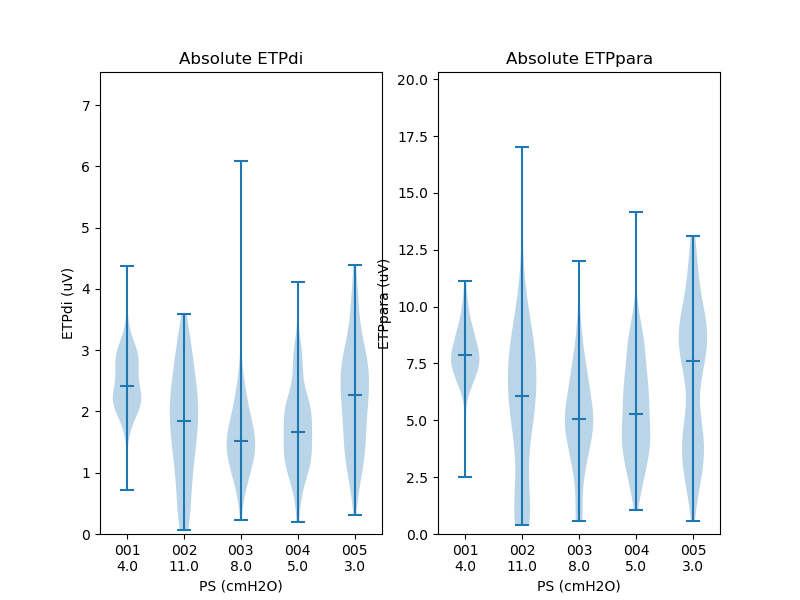

In [1252]:
# Plot the all ETPdi and ETPpara values, permissible and impermissible
fig_4, axis = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# sEAdi
msrt_values_di = list(set(df_di['measurement'].values))
msrt_values_di.sort()

PS_values = [list(set(
    df_di.loc[df_di['measurement'] == msrmt, 'PS_set'].values))[0]
    for msrmt in msrt_values_di]

all_data = [
    df_di.loc[
    (df_di['measurement'] == PS_set_tmp)
    & (df_di['ETP_di'] <= 5* np.percentile(df_di['ETP_di'].values, 95)), 
    'ETP_di'] for PS_set_tmp in msrt_values_di
] 


axis[0].violinplot(all_data,
                  showmeans=False,
                  showmedians=True)
axis[0].set_ylabel('ETPdi (uV)')
axis[0].set_xlabel('PS (cmH2O)')
axis[0].set_title('Absolute ETPdi')
axis[0].set_xticks([i+1 for i in range(len(msrt_values_di))])

str_labels_di = [(str(msrt_values_di[idx]) + '\n' + str(PS_values[idx]))
              for idx in range(len(msrt_values_di))]

axis[0].set_xticklabels(labels=str_labels_di)

ylims = axis[0].set_ylim()
axis[0].set_ylim((0, 2*np.percentile(df_di['ETP_di'].values, 95)))

# sEApara
msrt_values_para = list(set(df_para['measurement'].values))
msrt_values_para.sort()

PS_values = [list(set(
    df_para.loc[df_para['measurement'] == msrmt, 'PS_set'].values))[0]
    for msrmt in msrt_values_para]

all_data = [df_para.loc[
    (df_para['measurement'] == PS_set_tmp)
    & (df_para['ETP_para'] <= 5* np.percentile(df_para['ETP_para'].values, 95)), 
    'ETP_para'] for PS_set_tmp in msrt_values_para
]


axis[1].violinplot(all_data,
                  showmeans=False,
                  showmedians=True)
axis[1].set_ylabel('ETPpara (uV)')
axis[1].set_xlabel('PS (cmH2O)')
axis[1].set_title('Absolute ETPpara')
axis[1].set_xticks([i+1 for i in range(len(msrt_values_para))])

str_labels_para = [(str(msrt_values_para[idx]) + '\n' + str(PS_values[idx]))
              for idx in range(len(msrt_values_para))]

axis[1].set_xticklabels(labels=str_labels_para)

ylims = axis[1].set_ylim()
axis[1].set_ylim((0, 2*np.percentile(df_para['ETP_para'].values, 95) ))


In [1253]:
# Move on to the next measurement
if PS_step_chosen in df_Vvent['measurement'].to_list():
    if PS_step_idx >= 5:
        print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_Vvent['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. You can continue to the '
              + 'saving the overall data!')
              
    elif PS_step_chosen != list_of_numbers_string[PS_step_idx]:
        print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_Vvent['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. Run the next PEEP step, '
              + 'starting at step 2C.')
    else:
        PS_step_idx += 1
        if PS_step_idx >= 5:
            print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_Vvent['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. You can continue to the '
              + 'saving the overall data!')
        else:
            print('Data of measurement ' + PS_step_chosen + ' added to the '
              + 'dataframe. PS step ' + str(PS_step_chosen) + ' (' +
              str(len(set(df_Vvent['measurement'].values))) + '/5) is '
              + 'successfully evaluated and stored. Run the next PEEP step, '
              + 'starting at step 2C.')
else:
    print('Data of measurement ' + PS_step_chosen + ' not yet added to the ' 
        + 'dataframe!')

Data of measurement 005 added to the dataframe. PS step 005 (5/5) is successfully evaluated and stored. You can continue to the saving the overall data!


['To next PS step'](#section_ps_step)

In [1254]:
# Store session data if complete
if ((len(set(df_Vvent['measurement'].values)) < 5) |
    (measurement_date != measurement_dates[date_idx])):
    print('Warning: Not 5 PS settings evaluated yet!')
else:
    df_di.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient
              +'_sEAdi.csv')
    df_para.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient
              +'_sEApara.csv')
    df_Paw.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient
              +'_Paw.csv')
    df_Vvent.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient
              +'_Vvent.csv')

    fig_4.savefig(main_output_dir + '/' + patient + '/' 
                      + measurement_date  + '/' + measurement_date 
                      + '_' + patient + '_ETPs_scatter.png', dpi=300)

    
    print('Notification: Data of 5 PS settings stored!')
    print(measurement_date)

Notification: Data of 5 PS settings stored!
2022-01-03_13-11-09


In [1255]:
# Move on to the next measurement date if data saved

if not os.path.exists(main_output_dir + '/' + patient + '/' + measurement_date  
                      + '/' + measurement_date + '_' + patient +'_Vvent.csv'):
    print('Warning: Data not stored! Do not progress to next date!')
elif ((len(set(df_Vvent['measurement'].values)) < 5) |
    (measurement_date != measurement_dates[date_idx])):
    print('Warning: Data not stored! Do not progress to next date!')
else:
    date_idx += 1
    if date_idx < len(measurement_dates):
        print('Notification: Data appropriately stored. '
              +'You may progress to next date:')
        print(measurement_dates[date_idx])
    else:
        if patient == patients[patient_idx]:
            patient_idx += 1
            date_idx = 0
        print('Notification: Data appropriately stored. \n'+
              'This was the last measurement of this patient. '
              +'You may progress to next patient!')

Notification: Data appropriately stored. You may progress to next date:
No_NMC


In [1209]:
# # Save data anyway:
# df_di.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
#             + '/' + measurement_date + '_' + patient
#             +'_sEAdi.csv')
# df_para.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
#             + '/' + measurement_date + '_' + patient
#             +'_sEApara.csv')
# df_Paw.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
#             + '/' + measurement_date + '_' + patient
#             +'_Paw.csv')
# df_Vvent.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
#             + '/' + measurement_date + '_' + patient
#             +'_Vvent.csv')

# fig_4.savefig(main_output_dir + '/' + patient + '/' 
#                     + measurement_date  + '/' + measurement_date 
#                     + '_' + patient + '_ETPs_scatter.png', dpi=300)

# # bp_di.figure.savefig(main_output_dir + '/' + patient + '/' 
# #                     + measurement_date  + '/' + measurement_date 
# #                     + '_' + patient + '_sEAdi_scatter.png', dpi=300)


# # bp_para.figure.savefig(main_output_dir + '/' + patient + '/' 
# #                   + measurement_date  + '/' + measurement_date 
# #                   + '_' + patient + '_sEApara_scatter.png', dpi=300)

# date_idx += 1
# if date_idx < len(measurement_dates):
#     print('Notification: Data appropriately stored. '
#             +'You may progress to next date!')
#     print(measurement_date)
# else:
#     if patient == patients[patient_idx]:
#         patient_idx += 1
#         date_idx = 0
#     print('Notification: Data appropriately stored. \n'+
#             'This was the last measurement of this patient. '
#             +'You may progress to next patient!')


In [1161]:
# # Move on to the next measurement date
# date_idx += 1

In [1162]:
# # Move on to the previous measurement date
# date_idx -= 1

In [1110]:
# date_idx

['To next measurement date'](#section_date_step)

In [1111]:
# Move on to the next patient
# patient_idx += 1

In [1112]:
# # Move on to the previous patient
# patient_idx -= 1

['To next patient'](#section_patient_step)

In [1113]:
# gate_twice = True

# Normalisation of ETPs

In [ ]:
# # Normalise the ETPdi, PTPocc and NMCdi values relative to PEEP = 9 cmH2O:
# PEEP_norm = 9
# if len(set(df.loc[df['PEEP_set'] == PEEP_norm, 'PEEP_set'].values)) != 1:
#     print('Warning: PEEP = ', PEEP_norm, ' cmH2O is not available yet. ',
#           'Run that dataset first!')
# else:
#     # Strict
#     PTP_PEEP9_strict = np.median(output_df.loc[
#         quality_df_bool_strict.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'PTP_occs']
#     )
#     ETP_PEEP9_strict = np.median(output_df.loc[
#         quality_df_bool_strict.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'ETP_di_occs']
#     )
#     output_df = output_df.assign(PTP_norm_strict=
#                      output_df['PTP_occs'] / PTP_PEEP9_strict)
#     output_df = output_df.assign(ETP_norm_strict=
#                      output_df['ETP_di_occs'] / ETP_PEEP9_strict)
#     output_df = output_df.assign(NMC_di_norm_strict=
#                      output_df['PTP_norm_strict'] / 
#                      output_df['ETP_norm_strict'])
#     # Tolerant
#     PTP_PEEP9_tolerant = np.median(output_df.loc[
#         quality_df_bool_tolerant.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'PTP_occs']
#     )
#     ETP_PEEP9_tolerant = np.median(output_df.loc[
#         quality_df_bool_tolerant.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'ETP_di_occs']
#     )
#     output_df = output_df.assign(PTP_norm_tol=
#                      output_df['PTP_occs'] / PTP_PEEP9_tolerant)
#     output_df = output_df.assign(ETP_norm_tol=
#                      output_df['ETP_di_occs'] / ETP_PEEP9_tolerant)
#     output_df = output_df.assign(NMC_di_norm_tol=
#                      output_df['PTP_norm_tol'] / output_df['ETP_norm_tol'])

# print(output_df)

In [ ]:
# # Plot the normalised NMCdi values, permissible according to the tolerant 
# # criteria
# if len(set(df['PS_set'].values)) < 4:
#     print('Warning: Not 4 PS settings evaluated yet!')
# else:
#     passed_all_tolerant_crit = quality_df_bool_strict.all(axis=1)

#     bp = output_df[passed_all_tolerant_crit].plot.scatter('PEEP_set', 
#                                                    'NMC_di_norm_strict')
#     bp.set_ylabel('Normalised NMC_di (.)')
#     bp.set_xlabel('PEEP (cmH2O)')
#     bp.set_title('Normalised')
#     ylims = bp.set_ylim()
#     bp.set_ylim((0, ylims[1]))